# Case Plotting Using the C3 Python Connector 

C3's Python connector makes querying the C3 Datalake much simpler than using the Publicly available Restful API. Similarly, we start by importing all needed modules, with the notable absence of the requests module (no longer needed) and the addition of the c3python module. This DTI curated python module helps make connecting to c3 through python as simple as possible.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import dateutil
import datetime
import numpy as np
import json
import os
import re

## Make the connection to C3

This cell checks whether the `c3` object has already been defined. (It has if you are using the C3 integrated jupyter notebook). If it hasn't, it uses the `get_c3` function to establish the connection to c3 and get the c3 object.

In [ ]:
try:
    # Check whether the c3 object is defined
    c3
except NameError:
    # Connect to a c3 cluster and create the c3 object
    from c3python import get_c3
    c3 = get_c3('<vanity_url>', '<tenant>', '<tag>')

With the `c3` object, we can now explore C3 types, execute C3 functions on the platform, and get data out of the platform.

## Dataset Exploration - Locations

We're interested in plotting cases over time for various locations. Before we do this, we need to know the id for the various locations we're interested in. For this test, we're interested in a couple counties in the state of Illinois. First, we fetch outbreakLocations whose id contains the substring 'Illinois' and include some additional information so we can check the data.


Generally, we want to invoke the `fetch` command, to which we need to pass a `FetchSpec` type containing the parameters of our fetch search. Most commands within C3 accept some kind of Spec object. Let's review quickly how to inspect the available C3 documentation to find out the right way to call `fetch`. a simple `help` with the type we're interested in will do here.

In [3]:
# Get help documentation for the OutbreakLocation type
help(c3.OutbreakLocation)

If you search for the string `fetch:` you should quickly find the `fetch` function which specifies it takes a spec parameter of type `FetchSpec`. Let's have a look at the `FetchSpec` type.

In [4]:
help(c3.FetchSpec)

Careful inspection of the `FetchSpec` documentation shows no properties are required, but there are a few of interest.

* `filter`: This property defines an expression which is used to remove undesired types.
* `include`: This property defines which properties of the type to return in the fetch result. In some cases, you may not be interested in all type properties.
* `limit`: This property specifies how many instances to return at most. -1 indicates all instances should be returned.
* `offset`: If you don't want all instances, you can start returning with an offset. For instance, if offset is 10, start at the 10th instance, and return limit instances after.

The documentation above for each of these properties should also be quite clear.

## Executing C3 commands through the C3 connector

So now that we know what properties are available, and what arguments are needed, how do we actually perform a fetch call through the python connector? There are actually two ways to do this.

1. Create a C3 Spec type with the parameters of the search, and pass this to the function
2. Create a dictionary defining all needed parameters. This will be automatically converted to the correct Spec type by the C3 connector.

We'll now demonstrate both methods to perform the same search on OutbreakLocation types for Illinois specific OutbreakLocations.

In [5]:
# Building C3 Spec type first method

spec = c3.FetchSpec(
    filter = 'contains(id, "Illinois")',
    include = 'id, name, fips, lineList',
    limit = -1,
    offset = 0
)

# execute fetch command
res = c3.OutbreakLocation.fetch(spec=spec)

### Visualizing fetch results

With the fetch result above, we now want a neat way to view it. Thankfully, the `toJson` function helps us greatly. We can simply get the objects from the resulting value, call the `toJson` function, then use this to create a pandas DataFrame. This gives a nice visualization of the results.

In [6]:
pd.DataFrame(res.objs.toJson())

,type,typeIdent,id,name,meta,version,fips,lineList
0,OutbreakLocation,EP_LOC,Adams_Illinois_UnitedStates,Adams,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",1376267,"{'type': 'FipsCodeLookup', 'id': '17001'}",NaN
1,OutbreakLocation,EP_LOC,Alexander_Illinois_UnitedStates,Alexander,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",4390922,"{'type': 'FipsCodeLookup', 'id': '17003'}",NaN
2,OutbreakLocation,EP_LOC,Bond_Illinois_UnitedStates,Bond,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",4849674,"{'type': 'FipsCodeLookup', 'id': '17005'}",NaN
3,OutbreakLocation,EP_LOC,Boone_Illinois_UnitedStates,Boone,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",4325386,"{'type': 'FipsCodeLookup', 'id': '17007'}",NaN
4,OutbreakLocation,EP_LOC,Brown_Illinois_UnitedStates,Brown,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3670026,"{'type': 'FipsCodeLookup', 'id': '17009'}",NaN
...,...,...,...,...,...,...,...,...
106,OutbreakLocation,EP_LOC,Whiteside_Illinois_UnitedStates,Whiteside,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3801097,"{'type': 'FipsCodeLookup', 'id': '17195'}",NaN
107,OutbreakLocation,EP_LOC,Will_Illinois_UnitedStates,Will,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3604491,"{'type': 'FipsCodeLookup', 'id': '17197'}","[{'type': 'LineListRecord', 'id': '005-14858',..."
108,OutbreakLocation,EP_LOC,Williamson_Illinois_UnitedStates,Williamson,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3735561,"{'type': 'FipsCodeLookup', 'id': '17199'}",NaN
109,OutbreakLocation,EP_LOC,Winnebago_Illinois_UnitedStates,Winnebago,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3735563,"{'type': 'FipsCodeLookup', 'id': '17201'}","[{'type': 'LineListRecord', 'id': '005-14869',..."


In [7]:
# Executing the fetch with a simple dictionary

res = c3.OutbreakLocation.fetch(spec = {
    'filter': 'contains(id, "Illinois")',
    'include': 'id, name, fips, lineList',
    'limit': -1,
    'offset': 0
})

In [8]:
pd.DataFrame(res.objs.toJson())

,type,typeIdent,id,name,meta,version,fips,lineList
0,OutbreakLocation,EP_LOC,Adams_Illinois_UnitedStates,Adams,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",1376267,"{'type': 'FipsCodeLookup', 'id': '17001'}",NaN
1,OutbreakLocation,EP_LOC,Alexander_Illinois_UnitedStates,Alexander,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",4390922,"{'type': 'FipsCodeLookup', 'id': '17003'}",NaN
2,OutbreakLocation,EP_LOC,Bond_Illinois_UnitedStates,Bond,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",4849674,"{'type': 'FipsCodeLookup', 'id': '17005'}",NaN
3,OutbreakLocation,EP_LOC,Boone_Illinois_UnitedStates,Boone,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",4325386,"{'type': 'FipsCodeLookup', 'id': '17007'}",NaN
4,OutbreakLocation,EP_LOC,Brown_Illinois_UnitedStates,Brown,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3670026,"{'type': 'FipsCodeLookup', 'id': '17009'}",NaN
...,...,...,...,...,...,...,...,...
106,OutbreakLocation,EP_LOC,Whiteside_Illinois_UnitedStates,Whiteside,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3801097,"{'type': 'FipsCodeLookup', 'id': '17195'}",NaN
107,OutbreakLocation,EP_LOC,Will_Illinois_UnitedStates,Will,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3604491,"{'type': 'FipsCodeLookup', 'id': '17197'}","[{'type': 'LineListRecord', 'id': '005-14858',..."
108,OutbreakLocation,EP_LOC,Williamson_Illinois_UnitedStates,Williamson,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3735561,"{'type': 'FipsCodeLookup', 'id': '17199'}",NaN
109,OutbreakLocation,EP_LOC,Winnebago_Illinois_UnitedStates,Winnebago,"{'type': 'Meta', 'fetchInclude': '[id,name,fip...",3735563,"{'type': 'FipsCodeLookup', 'id': '17201'}","[{'type': 'LineListRecord', 'id': '005-14869',..."


Okay, so let's pick a couple counties from Illinois, we'll go with, Champaign, DuPage, and Cook. These have the following OutbreakLocation ids:

* Champaign: `Champaign_Illinois_UnitedStates`,
* DuPage: `DuPage_Illinois_UnitedStates`,
* Cook: `Cook_Illinois_UnitedStates`

In [9]:
ids = ['Champaign_Illinois_UnitedStates', 'DuPage_Illinois_UnitedStates', 'Cook_Illinois_UnitedStates']

## Fetch Case data from evalmetrics API

While the Datalake public API documentation provides several metrics we can evaluate, because we have access to the C3 AI Suite, we can actually obtain a bit more information, and look around at our expression options before settling on a metric to use. Because the `OutbreakLocation` type mixes in the `MetricEvaluatable` type, we can use the `listMetrics` method. (Have a look at the `OutbreakLocation` documentation to find this method!)

### Using `listMetrics` to see available Metrics.

Let's use the `listMetrics` method and put the results into a pandas DataFrame to see what options we have to choose from.

In [10]:
available_metrics_df = pd.DataFrame(c3.OutbreakLocation.listMetrics().toJson())
available_metrics_df

,type,name,expression,meta,id,version,srcType,path,tsDecl,unit,cache
0,SimpleMetric,ARITreatment_PercentUnder5,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ARITreatment_PercentUnder5_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.STA....,NaN,NaN,NaN
1,SimpleMetric,ATMs,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ATMs_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'FB.ATM....,NaN,NaN,NaN
2,SimpleMetric,AgeDependencyRatio,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
3,SimpleMetric,AgeDependencyRatio_Old,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_Old_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
4,SimpleMetric,AgeDependencyRatio_Young,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_Young_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2754,SimpleMetric,WomenMarriedby15,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WomenMarriedby15_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.M15....,NaN,NaN,NaN
2755,SimpleMetric,WomenMarriedby18,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WomenMarriedby18_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.M18....,NaN,NaN,NaN
2756,SimpleMetric,newHIVInfection,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",newHIVInfection_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.HIV....,NaN,NaN,NaN
2757,SimpleMetric,newHIVInfections_0_14,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",newHIVInfections_0_14_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.HIV....,NaN,NaN,NaN


Whoa! That's ALOT of metrics! Many more than are available through the Public API! Lets focus on metrics associated with Confirmed cases. Let's search through this list for metrics whose name contains the word `Confirmed`.

In [11]:
available_metrics_df[available_metrics_df.name.apply(lambda n: True if 'Confirmed' in n else False)]

,type,name,expression,meta,id,version,srcType,path,tsDecl,unit,cache
1505,SimpleMetric,ConfirmedCases,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedCases_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,NaN,NaN,NaN
1506,SimpleMetric,ConfirmedCasesAtlantic,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedCasesAtlantic_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,NaN,NaN,NaN
1507,SimpleMetric,ConfirmedCasesCovidTrackingProject,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedCasesCovidTrackingProject_OutbreakLoc...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,NaN,NaN,NaN
1508,SimpleMetric,ConfirmedCasesCovidTrackingProjectRaw,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedCasesCovidTrackingProjectRaw_Outbreak...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
1509,SimpleMetric,ConfirmedCasesECDC,"interpolate(rolling('SUM', sum(normalized.data...","{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedCasesECDC_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2673,SimpleMetric,UniversityOfWashington_Confirmed_infections_Hist,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",UniversityOfWashington_Confirmed_infections_Hi...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",hospitalPredictionSet.(measurementType=='confi...,"{'type': 'TSDecl', 'data': 'hospitalPrediction...",NaN,NaN
2740,SimpleMetric,WHO_ConfirmedCases,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WHO_ConfirmedCases_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",aggregateMeasurements.(measurementType == 'con...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
2741,SimpleMetric,WHO_ConfirmedCasesInterpolated,sum(sum(normalized.data.value)),"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WHO_ConfirmedCasesInterpolated_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",aggregateMeasurements.(measurementType == 'con...,NaN,NaN,NaN
2742,SimpleMetric,WHO_ConfirmedDeaths,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WHO_ConfirmedDeaths_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",aggregateMeasurements.(measurementType == 'dea...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN


That's still quite a few options, let's narrow it down to John's Hopkin's data.

In [12]:
available_metrics_df[available_metrics_df.name.apply(lambda n: True if (('Confirmed' in n) and ('JHU' in n)) else False)]

,type,name,expression,meta,id,version,srcType,path,tsDecl,unit,cache
1511,SimpleMetric,ConfirmedCasesJHU,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedCasesJHU_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,NaN,NaN,NaN
1512,SimpleMetric,ConfirmedCasesJHURaw,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedCasesJHURaw_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
1524,SimpleMetric,ConfirmedDeathsJHU,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedDeathsJHU_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,NaN,NaN,NaN
1525,SimpleMetric,ConfirmedDeathsJHURaw,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedDeathsJHURaw_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
1536,SimpleMetric,ConfirmedRecoveriesJHU,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedRecoveriesJHU_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,NaN,NaN,NaN
1537,SimpleMetric,ConfirmedRecoveriesJHURaw,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ConfirmedRecoveriesJHURaw_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",denormDescendants.to.pointMeasurements.(measur...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
1883,SimpleMetric,JHU_ConfirmedCases,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",JHU_ConfirmedCases_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",aggregateMeasurements.(measurementType == 'con...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
1884,SimpleMetric,JHU_ConfirmedCasesInterpolated,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",JHU_ConfirmedCasesInterpolated_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",aggregateMeasurements.(measurementType == 'nor...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
1885,SimpleMetric,JHU_ConfirmedDeaths,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",JHU_ConfirmedDeaths_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",aggregateMeasurements.(measurementType == 'dea...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN
1886,SimpleMetric,JHU_ConfirmedDeathsInterpolated,NaN,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",JHU_ConfirmedDeathsInterpolated_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",aggregateMeasurements.(measurementType == 'nor...,"{'type': 'TSDecl', 'data': 'data', 'treatment'...",NaN,NaN


Okay, Let's narrow that list down to `JHU_ConfirmedCases`, `JHU_ConfirmedDeaths`, and `JHU_ConfirmedRecoveries`.

In [13]:
expressions = ['JHU_ConfirmedCases', 'JHU_ConfirmedDeaths', 'JHU_ConfirmedRecoveries']

### Extracting timeseries data through the evalmetrics method.

Armed with the ids of the counties we want to extract data from, and the expressions we want to evluate, we can  form an `EvalMetricsSpec` and run the `evalMetrics` method to get a set of uniform and normalized timeseries.

Similarly to the `FetchSpec` above, the `EvalMetricsSpec` has a series of fields which can be filled to define the timeseries to evaluate. Let's look at the help documentation for the `EvalMetricsSpec`.

In [14]:
help(c3.EvalMetricsSpec)

We can see that the required parameters are `expressions`, `start`, `end`, and `interval`. Additionally, you can also specify `ids` as a list if you want expressions evaluated only on specific instances of types.

Thankfully, we already know which expressions and ids to use, so we only need to find out what time limits we should use for `start`, `end`, and `interval`. Well, the start of the pandemic outside China was around the beginning of February, so a good option for `start` would be `2020-02-01`. For `end` we should just pick now, and for `interval`, the usual measure is one value per day, so we'd use `DAY`.

In [82]:
start = '2020-02-01'
end = datetime.datetime.now().strftime('%Y-%m-%d')
interval = 'DAY'

Now, similarly to above, we can choose multiple methods to define the `EvalMetricsSpec` type. This time, we'll use the dictionary method.

In [83]:
spec = {
    'ids': ids,
    'expressions': expressions,
    'start': start,
    'end': end,
    'interval': interval
}
res = c3.OutbreakLocation.evalMetrics(spec=spec)
res

c3.EvalMetricsResult(
 result=c3.Mapp<string, map<string,Timeseries>>({'Champaign_Illinois_UnitedStates': c3.Mapp<string, Timeseries>({'JHU_ConfirmedCases': c3.NormTimeseriesDouble(
                                                                     m_start=datetime.datetime(2020, 2, 1, 0, 0),
                                                                     m_end=datetime.datetime(2020, 7, 27, 0, 0),
                                                                     m_data=c3.Arry<double>([0.0,
                                                                              0.0,
                                                                              0.0,
                                                                              0.0,
                                                                              0.0,
                                                                              0.0,
                                                                              

Well, the result returned, but unfortunately, it's in a strange type. Thankfully, There's a C3 type for containing datasets aptly named `Dataset`. Additionally, this type also contains a helper function to turn `Dataset` instances into pandas DataFrames! So let's take advantage of that now, and see what we've got!

In [84]:
res_ds = c3.Dataset.fromEvalMetricsResult(res)
res_df = c3.Dataset.toPandas(dataset=res_ds)

In [85]:
res_df

,JHU_ConfirmedCases,JHU_ConfirmedDeaths,JHU_ConfirmedRecoveries
Champaign_Illinois_UnitedStates_2020-02-01T00:00:00,0.0,0.0,0.0
Champaign_Illinois_UnitedStates_2020-02-02T00:00:00,0.0,0.0,0.0
Champaign_Illinois_UnitedStates_2020-02-03T00:00:00,0.0,0.0,0.0
Champaign_Illinois_UnitedStates_2020-02-04T00:00:00,0.0,0.0,0.0
Champaign_Illinois_UnitedStates_2020-02-05T00:00:00,0.0,0.0,0.0
...,...,...,...
DuPage_Illinois_UnitedStates_2020-07-22T00:00:00,10531.0,500.0,0.0
DuPage_Illinois_UnitedStates_2020-07-23T00:00:00,10627.0,502.0,0.0
DuPage_Illinois_UnitedStates_2020-07-24T00:00:00,10701.0,506.0,0.0
DuPage_Illinois_UnitedStates_2020-07-25T00:00:00,10771.0,507.0,0.0


## Further parse DataFrame

Okay well, this dataframe is pretty good, but the index isn't particularly useful. Let's massage this index a bit.

In [86]:
# Let's setup a regular expression to split this into an id and a time.
find_parts = re.compile('^(.*)_([^_]*)$')

# This function grabs each part of the match and 
def split(r):
    idx = r.name
    match = find_parts.match(idx)
    if match is None:
        return [ None, None ]
    else:
        groups = match.groups()
        return [ groups[0], dateutil.parser.isoparse(groups[1]) ]
    
# Apply the split function to the result DataFrame.
split_res = res_df.apply(split, axis=1, result_type='expand').rename(columns={0: 'id', 1: 'date'})

# Add the newly computed columns to the result DataFrame. Also reindex and drop the original index.
res_df = pd.concat([split_res,res_df], axis=1).reset_index(drop=True)

# Finally, we re-establish a more sensible index
cases_df = res_df.set_index(['id', 'date'])

Okay, now we can plot the confirmed cases and deaths over time for each OutbreakLocation!

Text(0.5, 0, 'Date')

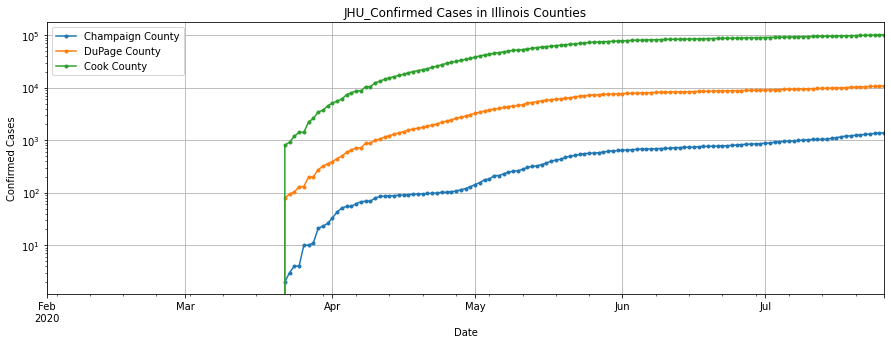

In [87]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'JHU_ConfirmedCases'
cases_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Cases in Illinois Counties")
ax.set_ylabel("Confirmed Cases")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

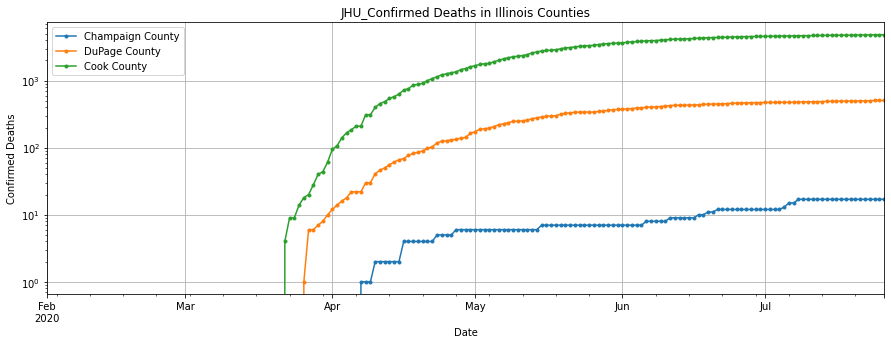

In [88]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'JHU_ConfirmedDeaths'
cases_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Deaths in Illinois Counties")
ax.set_ylabel("Confirmed Deaths")
ax.set_xlabel('Date')

## Get location information about Illinois Counties

Now, we'd like to augment these plots by plotting per-capita cases and deaths instead. First, we need to get each counties population. Here we grab the OutbreakLocation instances for each county we're interested in. We'll then explore the population properties which are available and pick one for our use.

In [89]:
Locations = {}
for Id in ids:
    Locations[Id] = c3.OutbreakLocation.get(Id)

We can look at the help documentation for the OutbreakLocation type to see all possible properties we could use, but not all types will have all of these properties defined. By fetching the specific types we're interested in, we can inspect them directly to see which properties they have. From this group, we can pick one we want to use.

Let's have a look at DuPage County.

In [90]:
Locations['DuPage_Illinois_UnitedStates']

c3.OutbreakLocation(
 typeIdent='EP_LOC',
 id='DuPage_Illinois_UnitedStates',
 name='Du Page',
 meta=c3.Meta(
        tenantTagId=7,
        tenant='covid',
        tag='dev',
        created=datetime.datetime(2020, 7, 17, 18, 29, 57, tzinfo=datetime.timezone.utc),
        createdBy='dataloader',
        updated=datetime.datetime(2020, 7, 27, 6, 19, 7, tzinfo=datetime.timezone.utc),
        updatedBy='dataloader',
        timestamp=datetime.datetime(2020, 7, 27, 7, 31, 51, tzinfo=datetime.timezone.utc),
        sourceFile='county_dex_processed.csv',
        fetchInclude='[]',
        fetchType='OutbreakLocation'),
 version=4522005,
 location=c3.PhysicalAssetLocation(
            timestamp=datetime.datetime(2020, 7, 26, 0, 0, tzinfo=datetime.timezone.utc),
            value=c3.Location(id='DuPage_Illinois_UnitedStates')),
 fips=c3.FipsCodeLookup(id='17043'),
 hospitalIcuBeds=219,
 hospitalStaffedBeds=1723,
 hospitalLicensedBeds=1928,
 latestTotalPopulation=922921.0,
 populationOfAllChil

Let's use `latestTotalPopulation` as each county's population.

## Build Per-Capita cases plots

We'll now need to divide each county's results from before by the population to get per-capita case and death count.

In [91]:
# Make a copy of the cases DataFrame
cases_per_capita_df = cases_df.copy()

In [92]:
# Build column of populations. Each row's value should get the population of the 'id' part of the index.
pops = cases_per_capita_df.index.to_series().apply(lambda t: Locations[t[0]].latestTotalPopulation)

In [93]:
# Divide each expression column by the constructed population column.
for expression in expressions:
    cases_per_capita_df.loc[:,expression] = cases_per_capita_df.loc[:,expression]/pops

In [94]:
cases_per_capita_df

JHU_ConfirmedCases  \
id                              date                             
Champaign_Illinois_UnitedStates 2020-02-01            0.000000   
                                2020-02-02            0.000000   
                                2020-02-03            0.000000   
                                2020-02-04            0.000000   
                                2020-02-05            0.000000   
...                                                        ...   
DuPage_Illinois_UnitedStates    2020-07-22            0.011411   
                                2020-07-23            0.011515   
                                2020-07-24            0.011595   
                                2020-07-25            0.011671   
                                2020-07-26            0.011783   

                                            JHU_ConfirmedDeaths  \
id                              date                              
Champaign_Illinois_UnitedStates 2020-02-01             0.000000   
                                2020-02-02             0.000000   
                                2020-02-03             0.000000   
                                2020-02-04             0.000000   
                                2020-02-05             0.000000   
...                                                         ...   
DuPage_Illinois_UnitedStates    2020-07-22             0.000542   
                                2020-07-23             0.000544   
                                2020-07-24             0.000548   
                                2020-07-25             0.000549   
                                2020-07-26             0.000549   

                                            JHU_ConfirmedRecoveries  
id                              date                                 
Champaign_Illinois_UnitedStates 2020-02-01                      0.0  
                                2020-02-02                      0.0  
                                2020-02-03                      0.0  
                                2020-02-04                      0.0  
                                2020-02-05                      0.0  
...                                                             ...  
DuPage_Illinois_UnitedStates    2020-07-22                      0.0  
                                2020-07-23                      0.0  
                                2020-07-24                      0.0  
                                2020-07-25                      0.0  
                                2020-07-26                      0.0  

[531 rows x 3 columns]

Finally, we can produce plots!

Text(0.5, 0, 'Date')

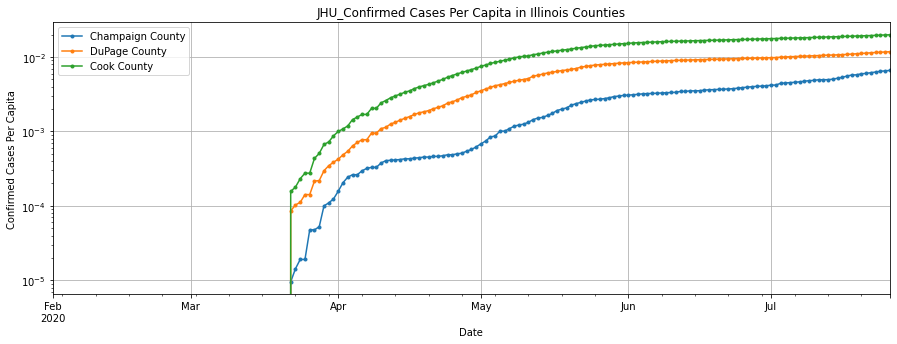

In [95]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'JHU_ConfirmedCases'
cases_per_capita_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Cases Per Capita in Illinois Counties")
ax.set_ylabel("Confirmed Cases Per Capita")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

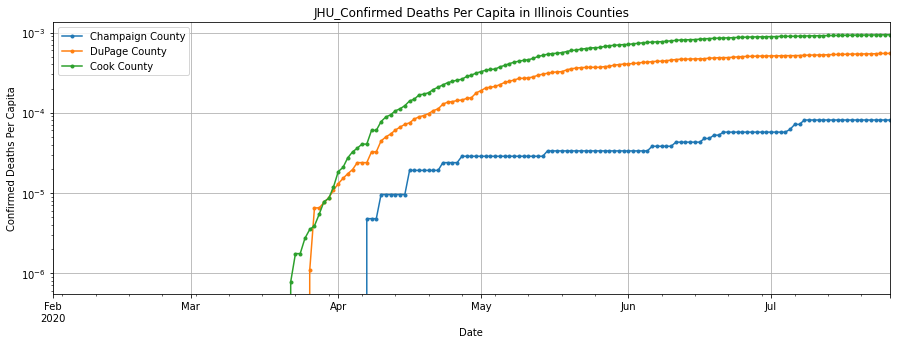

In [96]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'JHU_ConfirmedDeaths'
cases_per_capita_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Deaths Per Capita in Illinois Counties")
ax.set_ylabel("Confirmed Deaths Per Capita")
ax.set_xlabel('Date')

## Plot Daily New Cases And Deaths

All the values we've seen so far are totals up to the given day. What if we wanted to know the number of new cases or deaths on a given day and not the total? Well this can be done with a bit of pandas magic.

The handy `shift` function shifts a pandas Series or DataFrame by a specified amount. We can essentially subtract yesterday's values from the current day, then drop the days (first day in this case) whose subtraction is not defined.

Once the difference is defined, we can plot it just like we did before!

In [103]:
def build_case_differences(df, expressions):
    for expression in expressions:
        data = df[expression]
        df['new_{}'.format(expression)] = data-data.shift(1)
    df = df.dropna()
    return df

In [113]:
cases_df = build_case_differences(cases_df, expressions)

Finally, we can produce the plots!

Text(0.5, 0, 'Date')

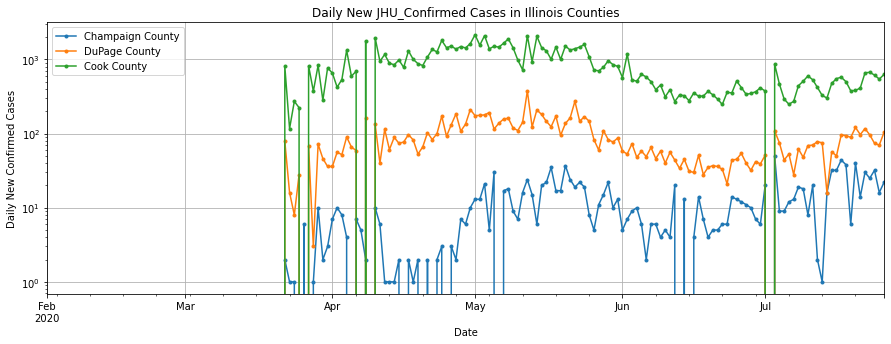

In [114]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'new_JHU_ConfirmedCases'
cases_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("Daily New JHU_Confirmed Cases in Illinois Counties")
ax.set_ylabel("Daily New Confirmed Cases")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

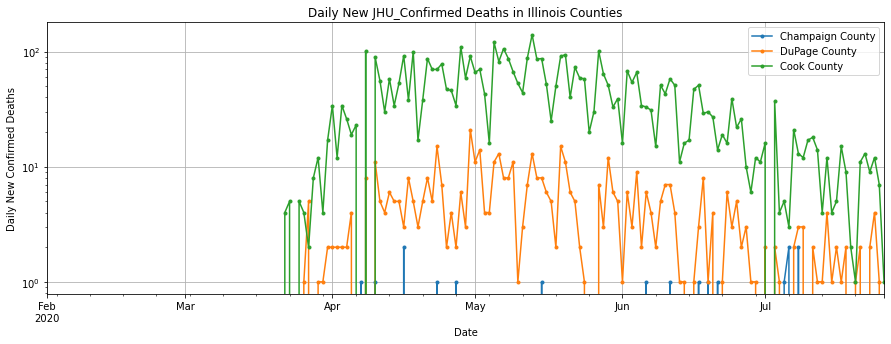

In [115]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'new_JHU_ConfirmedDeaths'
cases_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("Daily New JHU_Confirmed Deaths in Illinois Counties")
ax.set_ylabel("Daily New Confirmed Deaths")
ax.set_xlabel('Date')

## Per-Capita Daily New Cases And Deaths

Finally, we can divide by the population of each county as before to get the Per-Capita plots!

In [119]:
cases_per_capita_df = cases_df.copy()

In [120]:
# Divide each expression column by the constructed population column.
for expression in expressions:
    cases_per_capita_df.loc[:,expression] = cases_per_capita_df.loc[:,expression]/pops
    cases_per_capita_df.loc[:,"new_{}".format(expression)] = cases_per_capita_df.loc[:,"new_{}".format(expression)]/pops

Text(0.5, 0, 'Date')

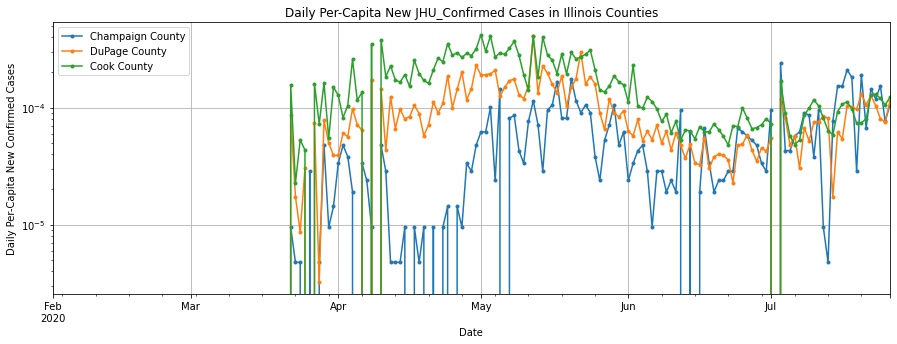

In [124]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'new_JHU_ConfirmedCases'
cases_per_capita_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("Daily Per-Capita New JHU_Confirmed Cases in Illinois Counties")
ax.set_ylabel("Daily Per-Capita New Confirmed Cases")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

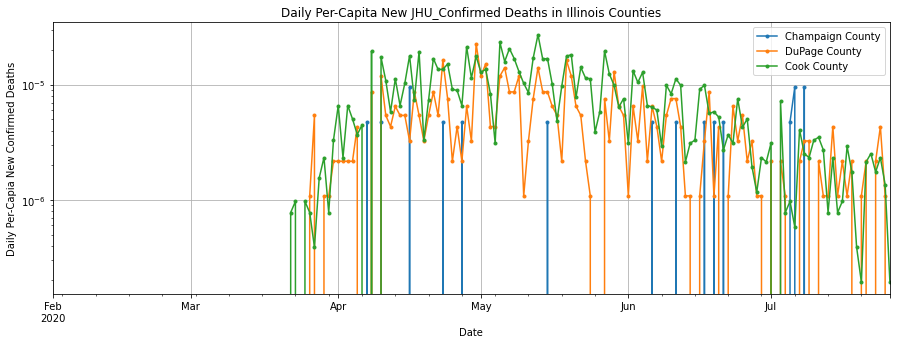

In [123]:
_, ax = plt.subplots(1, figsize=(15,5))

expression = 'new_JHU_ConfirmedDeaths'
cases_per_capita_df.loc['Champaign_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.loc['DuPage_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.loc['Cook_Illinois_UnitedStates'].plot(y=expression, ax=ax, marker='.', label='Cook County')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("Daily Per-Capita New JHU_Confirmed Deaths in Illinois Counties")
ax.set_ylabel("Daily Per-Capia New Confirmed Deaths")
ax.set_xlabel('Date')